# Gendist V1.0

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import jax
import optax
import dojax
import pickle
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import torchvision
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from augly import image
from sklearn.decomposition import PCA
from datetime import datetime
from flax import serialization
from multiprocessing import Pool
from loguru import logger

In [3]:
from tqdm.notebook import tqdm

In [4]:
import gendist
from gendist import training, processing

In [5]:
from gendist.models import MLPDataV1
from gendist.processing import flat_and_concat_params
from gendist.training import TrainingConfig, make_cross_entropy_loss_func

In [6]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [7]:
mnist_train = torchvision.datasets.MNIST(root=".", train=True, download=True)
mnist_test = torchvision.datasets.MNIST(root=".", train=False, download=True)

In [8]:
n_classes = 10
X_train = np.array(mnist_train.data)
y_train = np.array(mnist_train.targets)
y_train_ohe = jax.nn.one_hot(y_train, n_classes)

(60000, 784)
CPU times: user 0 ns, sys: 5.54 s, total: 5.54 s
Wall time: 4.88 s


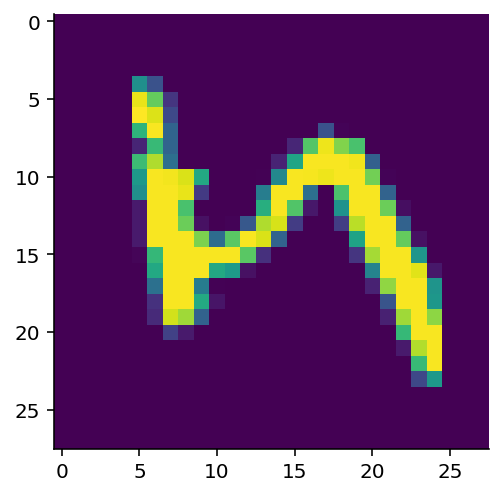

In [9]:
%%time
def processor(X, deg): return image.aug_np_wrapper(X, image.rotate, degrees=deg)
proc_class = gendist.processing.Factory(processor)

config = {"deg": 90}
res = proc_class(X_train, config)
print(res.shape)
plt.imshow(res[0].reshape(28, 28));

(60000, 784)
CPU times: user 58.9 ms, sys: 5.53 s, total: 5.59 s
Wall time: 5.23 s


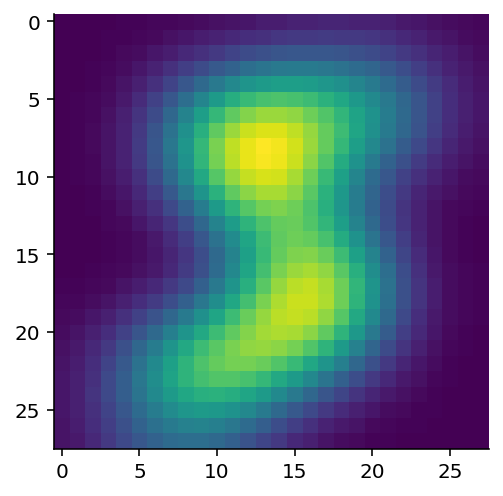

In [15]:
%%time

def processor(X, radius): return image.aug_np_wrapper(X, image.blur, radius=radius)
proc_class = gendist.processing.Factory(processor)

config = {"radius": 3.0}
res = proc_class(X_train, config)

print(res.shape)
plt.imshow(res[0].reshape(28, 28));

In [10]:
key = jax.random.PRNGKey(314)

batch_size = 2000
n_epochs = 150
alpha = 0.001
tx = optax.adam(learning_rate=alpha)

In [ ]:
def processor(X, radius): return image.aug_np_wrapper(X, image.blur, radius=radius)
proc_class = gendist.processing.Factory(processor)

model = MLPDataV1(n_classes)
radii = np.linspace(0.001, 3.00, 100)

train_config = TrainingConfig(model, proc_class, make_cross_entropy_loss_func, tx)
configs_params = []
configs_accuracy = []
for radius in tqdm(radii):
    config = {"radius": radius}
    params, train_acc = train_config.train_model_config(key, X_train, y_train_ohe,
                                                        config, n_epochs, batch_size)
    configs_params.append(params)
    configs_accuracy.append(train_acc)

In [83]:
date_str = datetime.now().strftime("%y%m%d")
filename = f"mnist-shift-params-{date_str}.pkl"
output_elements = {
    "configs": radii,
    "params": configs_params,
    "metric": configs_accuracy
}

with open(filename, "wb") as f:
    pickle.dump(output_elements, f)

In [14]:
with open("mnist-shift-params-220307.pkl", "rb") as f:
    output_elements = pickle.load(f)

    radii = output_elements["configs"]
    configs_params = output_elements["params"]
    configs_accuracy = output_elements["metric"]

In [15]:
configs_params_flat, fn_recontruct_params = dojax.flat_and_concat_params(configs_params)

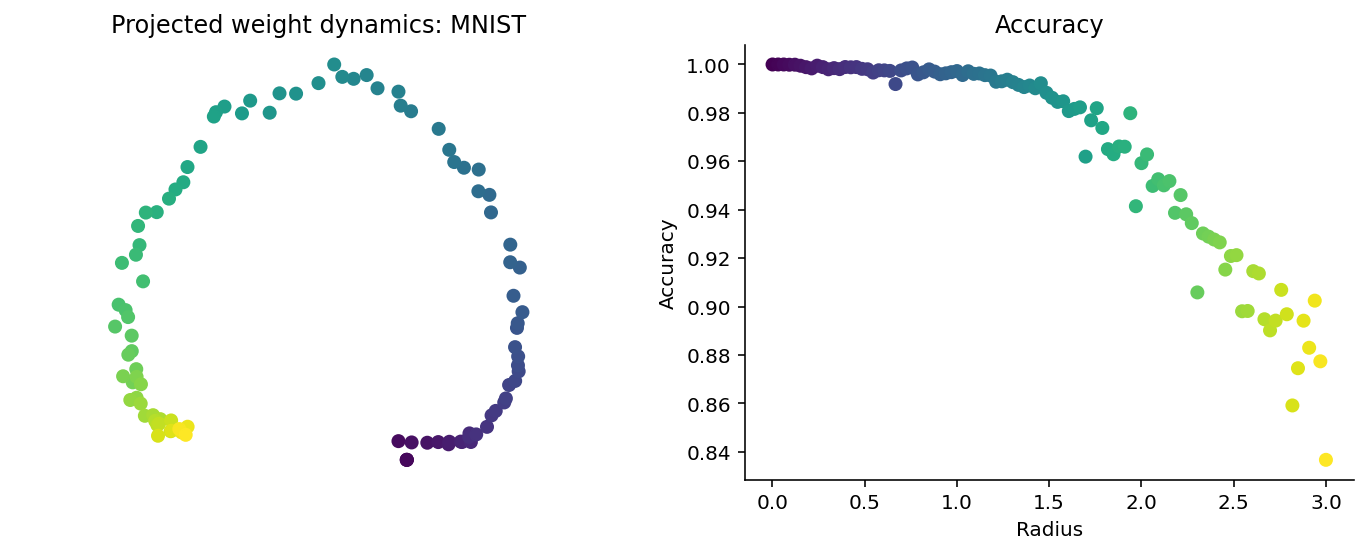

In [13]:
pca = PCA(n_components=2)
params_proj = pca.fit_transform(configs_params_flat)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].set_title("Projected weight dynamics: MNIST")
ax[0].scatter(*params_proj.T, c=radii)
# ax[0].cb(label="radius")
ax[0].tick_params(axis="both", labelleft=False, labelbottom=False)
ax[0].axis("equal")
ax[0].axis("off")


ax[1].set_title("Accuracy")
ax[1].scatter(radii, configs_accuracy, c=radii)
ax[1].set_xlabel("Radius")
ax[1].set_ylabel("Accuracy");

In [14]:
%%time

def processor(X, radius): return image.aug_np_wrapper(X, image.blur, radius=radius)
proc_class = gendist.processing.Factory(processor)

configs = [{"radius": rad} for rad in [0.01, 1.0, 2.0, 3.0]]
res = proc_class(X_train[:4], configs, 1)

CPU times: user 3.72 ms, sys: 123 ms, total: 127 ms
Wall time: 192 ms


https://symbolize.stripped_domain/r/?trace=557a15314ddb,7f93b078e3bf,557a1554011f&map= 
*** SIGTERM received by PID 1030860 (TID 1030860) on cpu 24 from PID 1029680; stack trace: ***
PC: @     0x557a15314ddb  (unknown)  insertdict
    @     0x7f93a003c7fa        992  (unknown)
    @     0x7f93b078e3c0  482090000  (unknown)
    @     0x557a15540120  (unknown)  (unknown)
https://symbolize.stripped_domain/r/?trace=557a15314ddb,7f93a003c7f9,7f93b078e3bf,557a1554011f&map=7a511a57244151c993b16b37978e7ed7:7f9391664000-7f93a03a6d50 
E0309 09:59:07.523883 1030860 coredump_hook.cc:320] RAW: Remote crash gathering disabled for SIGTERM.
E0309 09:59:07.541099 1030860 process_state.cc:770] RAW: Raising signal 15 with default behavior


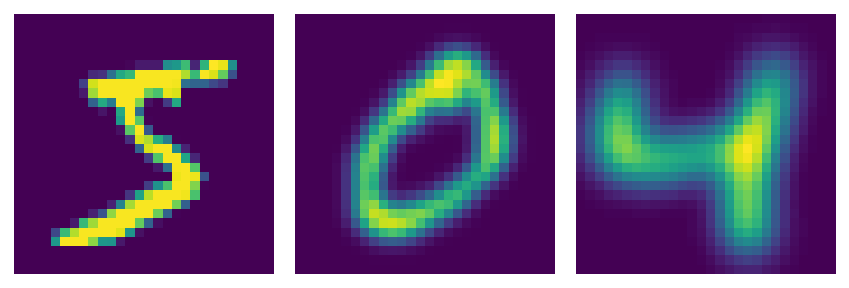

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(6, 3))
for axi, img in zip(ax,  res):
    axi.imshow(img.reshape(28, 28))
    axi.axis("off")
plt.tight_layout()

## Training weights

In [16]:
n_components = 60
pca = PCA(n_components=n_components)
params_proj = pca.fit_transform(configs_params_flat)

In [17]:
radii_dict = [{"radius": radius} for radius in radii]

In [18]:
n_train_subset = 6_000
subset_ix = pd.Series(y_train).sample(n_train_subset, random_state=314)
subset_ix = subset_ix.index.values
subset_ix

array([46242, 52277, 30471, ..., 18692,  3212,   220])

In [19]:
logger.add("training-weights-002.log", rotation="5mb")
logger.warning("Initialising process")

2022-03-09 11:52:46.218 | WARNING  | __main__:<module>:2 - Initialising process


In [22]:
def processor(X, radius): return image.aug_np_wrapper(X, image.blur, radius=radius)
proc_class = gendist.processing.Factory(processor)
alpha = 0.0001
tx = optax.adam(learning_rate=alpha)


weights_model = gendist.models.MLPWeightsV1(n_components)
train_config = gendist.training.TrainingShift(weights_model, proc_class,
                                              gendist.training.make_multi_output_loss_func,
                                              tx)

In [21]:
weigths_trained = None

In [ ]:
batch_size = 10_000
num_epochs = 10
weights_trained, losses = train_config.train(key, X_train[subset_ix], params_proj,
                                             radii_dict, batch_size, num_epochs, logger, weigths_trained)

In [25]:
with open("weights-dynamics.params", "wb") as f:
    bytes_params = serialization.to_bytes(weights_trained)
    f.write(bytes_params)

# Proxy zero-shot learning

In [9]:
model = MLPDataV1(n_classes)
radii = np.linspace(0.001, 3.00, 100)

In [32]:
with open("mnist-shift-params-220307.pkl", "rb") as f:
    output_elements = pickle.load(f)

    radii = output_elements["configs"]
    configs_params = output_elements["params"]
    configs_accuracy = output_elements["metric"]

with open("weights-dynamics.params", "rb") as f:
    weights_trained = weights_model.init(jax.random.PRNGKey(314), jnp.ones((1, 28 ** 2)))
    weights_trained = serialization.from_bytes(weights_trained, f.read())

In [33]:
logger.remove()

In [34]:
logger.add("projection-accuracy-full-new.log", rotation="5mb")

3

In [35]:
X_test = np.array(mnist_test.data)
y_test = np.array(mnist_test.targets)

In [ ]:
ix = 4
accuracy_configs_learned = []

for i, radius in enumerate(radii):
    x_test_shift = proc_class.process_single(X_test[4], radius=radius)
    predicted_weights = weights_model.apply(weights_trained, x_test_shift.ravel())
    reconstructed_predicted_weights = pca.inverse_transform(predicted_weights)
    reconstructed_predicted_weights = fn_recontruct_params(reconstructed_predicted_weights)
    
    X_test_shift_ravel = proc_class(X_test, {"radius": radius})
    y_test_hat = model.apply(reconstructed_predicted_weights, X_test_shift_ravel)
    y_test_hat = y_test_hat.argmax(axis=1)
    
    accuracy_learned = (y_test_hat == y_test).mean().item()
    accuracy_configs_learned.append(accuracy_learned)
    
    logger.info(f"{radius=:0.4f} | {accuracy_learned=:0.4f}")